# Neural networks

## Problem 1.1: regression

In this excersise we train a simple neural network to approximate a noisy sine function.

### Import Python modules

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
from torch import nn
import numpy as np

%matplotlib inline

### Set random seed

Needed for reproducibility of the results

In [2]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

### Define helper functions to generate training data

In [3]:
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Generate noisy sinusoidal observations at a random set of points.

  Returns:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)
  # y = f(x) + noise
  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

### Create training data

In [4]:
NUM_TRAINING_POINTS = 100
x, y = generate_1d_data(num_training_points=NUM_TRAINING_POINTS, observation_noise_variance=.1)

x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

y = y[:,None]

print(x.size())
print(y.size())

torch.Size([100, 1])
torch.Size([100, 1])


### Train neural network

#### Initialize parameters for learning

In [5]:
num_epochs = 5000
learning_rate = 0.01 
input_size = x.shape[1]

#### Define helper functions
Takes `torch.nn.Module` as an input and applies the specified weight initialization.

In [6]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(-0.01, 0.01)
        m.bias.data.fill_(0)

Define hook function to store hidden layer outputs in the `hidden_outputs` list.

In [7]:
hidden_outputs = []

def hook_fn(module, input, output):
    hidden_outputs.append(output)

#### Define a neural network 

Let's call it `SineModel`, since we are going to approximate a sine function.

In [8]:
class SineModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

#### Set number of hidden units

In [9]:
hidden_size = 5     # dont' change it unless you know what you are doing

#### Define empty array to save the training loss

In [10]:
e_tr = np.empty(num_epochs)

#### Create a model

In [11]:
model = SineModel(input_size, hidden_size)

# Register hook to the hidden layer
model.fc1.register_forward_hook(hook_fn)

# Apply the specified weight initialization.
model.apply(weights_init_uniform)

SineModel(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

#### Define loss and optimizer
For this regression problem we use the mean-square-error:
$$J(\mathbf{w}) = \frac{1}{n}\sum\limits_{i=1}^n(\hat{y}_i - y_i)^2$$
which is available in `pytorch` as `nn.MSELoss`.

As an optimizer we suggest to use `Adam` - stochastic gradient-based optimization method. See the [arxive paper](https://arxiv.org/abs/1412.6980) for more details.

In [12]:
# Define loss
criterion = nn.MSELoss() 
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

#### Run training of the neural network

In [13]:
for epoch in tqdm(range(num_epochs)):
    # Get our predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    # Save loss to the array for further visualization
    e_tr[epoch] = loss

  0%|          | 0/5000 [00:00<?, ?it/s]

### Visualize the training loss
- How does the loss change with training epoch?
- What does it mean? What does it say about quality of approximation?

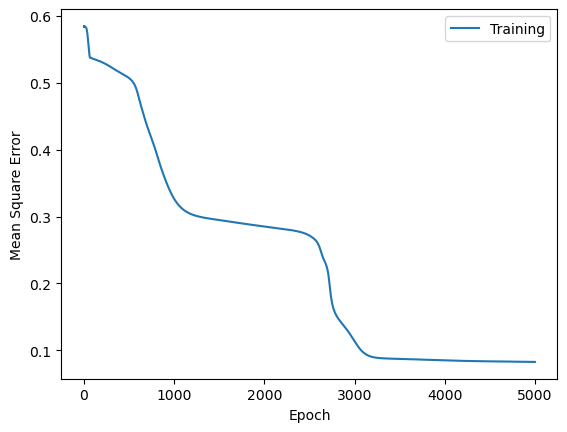

In [14]:
fig = plt.figure()
ax = plt.axes()
plt.plot(e_tr, label='Training')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

### Visualize the approximation result
- Evaluate quality: is it a good fit? Why?
- Change the **number of training epochs** in the line `num_epochs = 5000`, reinitialize the model and run the training again (the easiest way is to run all the cells (Run -> Run all cells)).
- How does the number of training epochs influence the training loss and the approximation quality? Why?

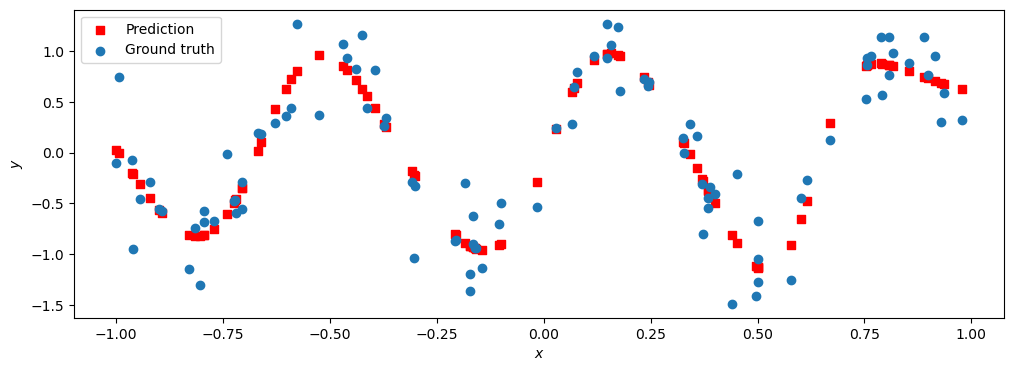

In [15]:
plt.figure(figsize=(12, 4))
plt.scatter(x.detach().numpy(), y_pred.detach().numpy(), color='r', marker='s', label='Prediction')
plt.scatter(x.detach().numpy(), y.detach().numpy(), label='Ground truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

### Visualize the hidden units

- Change the random seed to vary the weights initialization.  How does it influence the result?
- How do the values of hidden units (bottom plot) relate to the approximated function? Why?

Text(0.5, 0, '$x$')

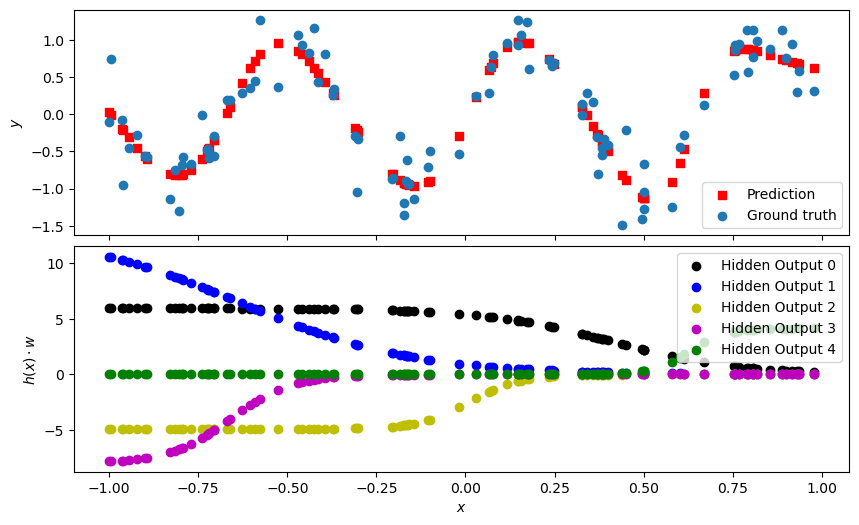

In [16]:
# get last hidden output
last_output = hidden_outputs[-1]

# get weights for the last hidden layer
w = model.fc2.weight.detach().numpy()[0]

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

ax[0].scatter(x.detach().numpy(), y_pred.detach().numpy(), color='r', marker='s', label='Prediction')
ax[0].scatter(x.detach().numpy(), y.detach().numpy(), label='Ground truth')
ax[0].set_ylabel(r'$y$')
ax[0].legend()

colors = ['k','b','y','m','g']
for i, c in enumerate(colors):
    label = "Hidden Output {num}"
    ax[1].scatter(x.detach().numpy(), torch.sigmoid(last_output[:,i]).detach().numpy()*w[i], color=c, label=label.format(num=i))
ax[1].legend()
ax[1].set_ylabel(r'$h(x)\cdot w$')
plt.xlabel(r'$x$')

In [17]:
# remove or comment the line below to run the complete notebook via Run->Run all cells
stop here

## Problem 1.2: gradient descent

In this excersise we train a simplified neural network to approximate the same noisy sine function as in a previous excersise. We will observe the work of the gradient descent by visualizing weights during the training and loss function. To enable this visualization, we have reduced the number of weights to train upto two: $w_1$ and $w_2$. 

### Define training parameters

In [18]:
num_epochs = 2000
learning_rate = 0.01 
input_size = x.shape[1]

### Define the new simplified neural network

Let's call it `SimpleModel`, since it has only 2 parameters to train.

In [19]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False) 
        self.fc2 = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

### Define empty arrays to save the data required for the visualization

In [20]:
# save weights during the training
w1_list = np.empty(num_epochs)
w2_list = np.empty(num_epochs)

# training loss vs. epoch
e_tr = np.empty(num_epochs)

### Create the model

In this excersise we fix the weights if the layer `fc2` and train only the weights of the layer `fc1`. Statement `required_grad=False` tells pytorch do not update the weights in the given layer. We also set the number of hidden units strictly to 2 to enable visualization. 

In [21]:
# create tensor with fixed weights
weights_fc2 = torch.tensor([[1.0], [-1.0]], dtype=torch.float)

# create the model
simple_model = SimpleModel(input_size, 2)
simple_model.fc2.weight = nn.Parameter(weights_fc2.T, requires_grad=False)

# check whether the weights have been set correctly
print(simple_model.fc2.weight)

Parameter containing:
tensor([[ 1., -1.]])


**Your task here**. Check the output: are the weights havee been set correctly?

### Compute and save the loss function in the given range

We need it for the visualization.

In [22]:
num=100
w0 = np.linspace (-2, 2, num=num)
w1 = np.linspace (-2, 2, num=num)
xx, yy = np.meshgrid (w0, w1)
z = np.zeros((num, num))

criterion = nn.MSELoss() # negative log likelihood loss
    
for i in range(num):
    for j in range(num):
        simple_model.fc1.weight = nn.Parameter(torch.tensor([[xx[i, j]], [yy[i, j]]], dtype=torch.float), requires_grad=True)
        y_pred = simple_model(x)
        z[i, j] = criterion(y_pred, y)

### Train the simplified model.

In [23]:
# define and set the initial weights for the layer fc1
weights_fc1 = torch.tensor([[-2.0], [2.0]], dtype=torch.float)
simple_model.fc1.weight = nn.Parameter(weights_fc1, requires_grad=True)

# define optimizer
optimizer = torch.optim.Adam(simple_model.parameters(), lr=learning_rate) 

# run training
for epoch in tqdm(range(num_epochs)):
    # Get our predictions
    y_pred = simple_model(x)
    
    loss = criterion(y_pred, y)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    # save the training loss
    e_tr[epoch] = loss.detach().numpy()

    # save the weights for visualization
    w1_list[epoch] = simple_model.fc1.weight[0].detach().numpy()[0]
    w2_list[epoch] = simple_model.fc1.weight[1].detach().numpy()[0]

    # uncomment the line below if you want to print the saved weights and loss
    #print("Epoch: {epoch}, Loss: {loss}, W1: {w1}, W2: {w2}".format(epoch=epoch, loss=e_tr[epoch], w1=w1_list[epoch], w2=w2_list[epoch]))

  0%|          | 0/2000 [00:00<?, ?it/s]

### Visualize the gradient descent

- Change the **learning rate** in the line `learning_rate = 0.01`, reinitialize model and optimizer and run the training again (just run all the cells of the present excersise).
- How does the learning rate influence the training loss and the approximation quality? Why? Does it influence anything else? What?
- Vary the initial values of the weights in the line `weights_fc1 = torch.tensor([[-2.0], [2.0]], dtype=torch.float)` in the block above. How do they influence the behaviour of the gradient descent?

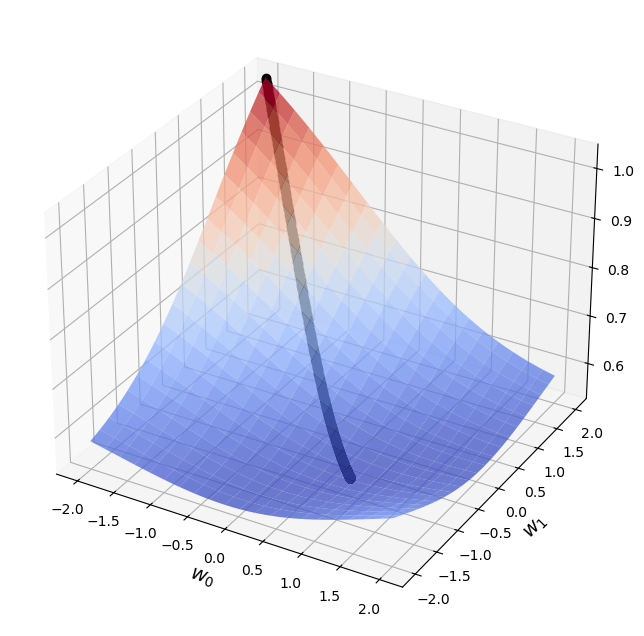

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection = '3d')

ax.plot_surface(xx, yy, z, rstride=5, cstride=5, cmap=cm.coolwarm, linewidth=1, antialiased=True, edgecolor='none', alpha=0.75)
ax.plot(w1_list, w2_list, e_tr, 'ko', linewidth=5)

# uncomment the two lines below and change the angles if you want to rotate the plot
#angles = (0, 0, 0)
#ax.view_init(elev=angles[0], azim=angles[1], roll=angles[2])

plt.xlabel(r"$w_0$", fontsize=14)
plt.ylabel(r"$w_1$", fontsize=14)
plt.show()